# Differential Error Rate analysis

This notebook generates some of the figures and stats from the m6A section of the nanopore paper

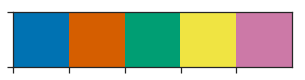

In [1]:
import sys
import re
import os
from glob import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

import pybedtools as pybt
import pyBigWig as pybw
import pysam


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

Make gzipped versions of the thresholded DER sites and miCLIP peaks for random access (used by metaplot functions)


In [4]:
%%bash
cat ../vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed | bgzip > vir1_VIRc_der_sites_thresholded.bed.gz
tabix -p bed vir1_VIRc_der_sites_thresholded.bed.gz

cat ../../miCLIP_pipeline/peaks/idr/miCLIP_expt1.CLIP_1_vs_miCLIP_expt2.CLIP_2.peaks.bed |
awk -v OFS='\t' '{print $1, $2, $3, "peak", $5, $6}' |
sort -k1,1 -k2,2n | bgzip > miclip_peaks.bed.gz
tabix -p bed miclip_peaks.bed.gz

In [5]:
def to_df(bt, colnames):
    return bt.to_dataframe(
        disable_auto_names=True,
        header=None,
        names=colnames
    )

### Log odds ratio histogram

plots of change in mismatches compared to reference base in vir-1 vs VIRc

Use all DER sites (unthresholded)

In [6]:
vir1_VIRc = pybt.BedTool('../vir1_VIRc_guppy/der_analysis/der_sites_with_logodds.bed')
len(vir1_VIRc)

21016

In [9]:
vir1_VIRc_df = to_df(
    vir1_VIRc,
    colnames=['chrom', 'start', 'end', 'name1', 'der_score', 'strand',
              'mm_logodds', 'der_g', 'der_pval', 'der_fdr', 'a_g', 'a_p', 'b_g', 'b_p']
)
vir1_VIRc_df.head()

,chrom,start,end,name1,der_score,strand,mm_logodds,der_g,der_pval,der_fdr,a_g,a_p,b_g,b_p
0,1,31295,31296,DER_site,2.0,-,1.54,23.85,4.57,1.78,3.54,0.74,3.78,0.93
1,1,45417,45418,DER_site,13.0,-,2.21,81.91,16.92,13.35,15.03,0.09,10.29,0.33
2,1,45463,45464,DER_site,8.0,-,2.08,61.00,11.75,8.41,7.35,0.60,6.82,0.87
3,1,47576,47577,DER_site,11.0,-,1.97,75.01,14.70,11.23,7.10,0.31,12.45,0.41
4,1,47577,47578,DER_site,25.0,-,2.60,141.64,28.90,25.00,7.23,0.30,8.99,0.70


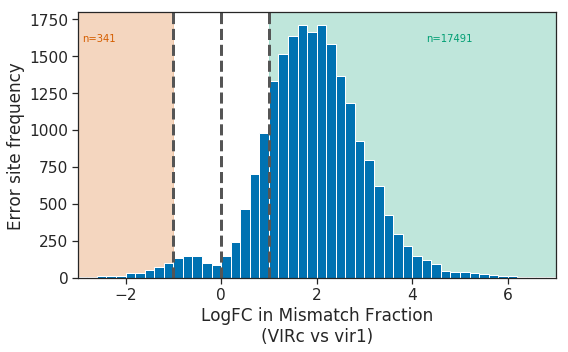

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(vir1_VIRc_df.mm_logodds, bins=np.linspace(-3, 7, 51), color=pal[0])
ax.axvline(-1, ls='--', color='#555555', lw=3)
ax.axvline(0, ls='--', color='#555555', lw=3)
ax.axvline(1, ls='--', color='#555555', lw=3)
ax.axvspan(-1, -3, color=pal[1], alpha=0.25, zorder=-1)
ax.axvspan(1, 7, color=pal[2], alpha=0.25, zorder=-1)
ax.set_xlim(-3, 7)
ax.annotate(s=f'n={sum(vir1_VIRc_df.mm_logodds < -1)}', xy=(-2.9, 1600), color=pal[1])
ax.annotate(s=f'n={sum(vir1_VIRc_df.mm_logodds > 1)}', xy=(4.3, 1600), color=pal[2])
ax.set_xlabel('LogFC in Mismatch Fraction\n(VIRc vs vir1)')
ax.set_ylabel('Error site frequency')
plt.tight_layout()
plt.savefig('figures/der_site_effect_size_histogram.svg')
plt.show()

Switch back to sites thresholded at logFC > 1 for rest of figures

In [11]:
vir1_VIRc = pybt.BedTool('../vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed')
vir1_VIRc_df = to_df(
    vir1_VIRc,
    colnames=['chrom', 'start', 'end', 'name1', 'der_score', 'strand',
              'mm_logodds', 'der_g', 'der_pval', 'der_fdr', 'a_g', 'a_p', 'b_g', 'b_p']
)
len(vir1_VIRc)

17491

In [13]:
%%bash
grep "protein_coding" /cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.gff |
awk \
  -v FS="[\t;]" -v OFS="\t" \
  '$3 == "gene" {print $1, $4 - 1, $5, $9, ".", $7}' | \
  sed -e 's/[";]//g' -e 's/^Chr//' -e 's/ID=//' \
> araport_genes.bed

In [14]:
%%bash
cat /cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.gff |
gawk \
  -v FS="\t" -v OFS="\t" \
  '$3 == "gene" {match($9, /locus_type=(\w*);?/, biotype); print $1, $4 - 1, $5, biotype[1], ".", $7}' | \
  sed -e 's/[";]//g' -e 's/^Chr//' -e 's/ID=//' \
> araport_biotypes.bed

In [15]:
genes = pybt.BedTool('araport_genes.bed')
biotypes = pybt.BedTool('araport_biotypes.bed')

In [17]:
miclip = pybt.BedTool('miclip_peaks.bed.gz')

In [18]:
len(miclip)

93046

In [19]:
der_genes = genes.intersect(vir1_VIRc, s=True, u=True)
non_der_genes = genes.intersect(vir1_VIRc, s=True, v=True)
der_sites_in_genes =vir1_VIRc.intersect(der_genes, s=True, u=True)
der_not_in_genes = vir1_VIRc.intersect(der_genes, s=True, v=True)
der_biotypes = biotypes.intersect(vir1_VIRc, s=True, u=True)
miclip_genes = genes.intersect(miclip, s=True, u=True)
len(der_genes), len(non_der_genes), len(miclip_genes), len(der_sites_in_genes), len(der_not_in_genes), len(der_biotypes)

(5097, 22558, 5540, 17390, 101, 5115)

## Distance from DER sites to nearest miCLIP figures

In [21]:
distance_to_miclip = to_df(
    vir1_VIRc.sort().closest(miclip.sort(), D="a", s=True),
    colnames=['chrom', 'der_start', 'der_end', 'name1', 'der_score', 'strand',
              'mm_logodds', 'der_g', 'der_pval', 'der_fdr', 'a_g', 'a_p', 'b_g', 'b_p',
              'chrom2', 'miCLIP_start', 'miCLIP_end', 'name2', 'miCLIP_cov', 'strand',
              'dist'])
distance_to_miclip.head()

/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,chrom,der_start,der_end,name1,der_score,strand,mm_logodds,der_g,der_pval,der_fdr,...,a_p,b_g,b_p,chrom2,miCLIP_start,miCLIP_end,name2,miCLIP_cov,strand.1,dist
0,1,31295,31296,DER_site,2.0,-,1.54,23.85,4.57,1.78,...,0.74,3.78,0.93,1,31295,31296,peak,853,-,0
1,1,45417,45418,DER_site,13.0,-,2.21,81.91,16.92,13.35,...,0.09,10.29,0.33,1,45461,45462,peak,618,-,-44
2,1,45463,45464,DER_site,8.0,-,2.08,61.00,11.75,8.41,...,0.60,6.82,0.87,1,45461,45462,peak,618,-,2
3,1,47576,47577,DER_site,11.0,-,1.97,75.01,14.70,11.23,...,0.31,12.45,0.41,1,47576,47577,peak,866,-,0
4,1,47577,47578,DER_site,25.0,-,2.60,141.64,28.90,25.00,...,0.30,8.99,0.70,1,47576,47577,peak,866,-,1


In [22]:
sum(np.abs(distance_to_miclip.dist) <= 5) / len(distance_to_miclip)

0.6567329529718052

In [23]:
np.median(np.abs(distance_to_miclip.dist))

2.0

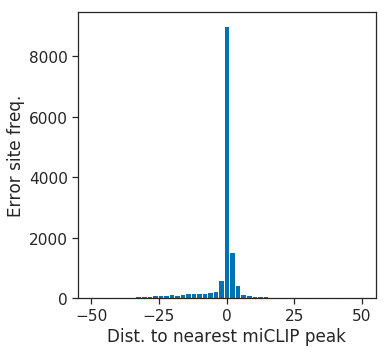

In [24]:
fig, ax = plt.subplots(figsize=(5.5, 5))
ax.hist(distance_to_miclip.dist,
        bins=np.linspace(-50, 50, 50),
        color=pal[0])
ax.set_xticks([-50, -25, 0, 25, 50])
ax.set_xlabel('Dist. to nearest miCLIP peak')
ax.set_ylabel('Error site freq.')
plt.tight_layout()
plt.savefig('figures/miclip_distance_to_der_site.svg')
plt.show()

## Motif found underneath error sties

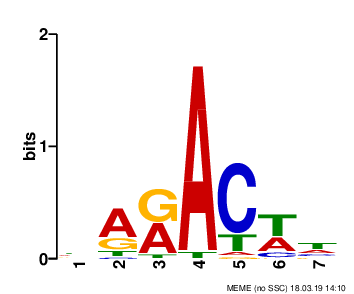

In [26]:
from IPython.display import display, Image

Image('../vir1_VIRc_guppy/motif_detection/motifs.meme/logo1.png')

## DER motif figures

The der motifs file contains all motifs found under error sites. There are some duplications where there are multiple error sites per m6A site

In [27]:
der_motifs = pybt.BedTool('../vir1_VIRc_guppy/motif_detection/der_motifs.gtf')
len(der_motifs)

4749

In [28]:
der_motifs.head()

1	fimo	nucleotide_motif	47575	47581	27.4	-	.	Name=DARACWW_1:47570-47585(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:47570-47585(-);pvalue=0.0018;qvalue=0.0746;sequence=TAAACTA;
 1	fimo	nucleotide_motif	50188	50194	24	-	.	Name=DARACWW_1:50184-50197(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:50184-50197(-);pvalue=0.00402;qvalue=0.0901;sequence=AGGACTA;
 1	fimo	nucleotide_motif	50238	50244	29.7	-	.	Name=DARACWW_1:50232-50252(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:50232-50252(-);pvalue=0.00108;qvalue=0.0664;sequence=GAGACTA;
 1	fimo	nucleotide_motif	121170	121176	28.2	-	.	Name=DARACWW_1:121166-121179(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:121166-121179(-);pvalue=0.00151;qvalue=0.0732;sequence=TAAACAT;
 1	fimo	nucleotide_motif	121205	121211	25.5	-	.	Name=DARACWW_1:121199-121212(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:121199-121212(-);pvalue=0.00281;qvalue=0.0801;sequence=TGGACAT;
 1	fimo	nucleotide_motif	121205	121211	25.5	-	.	Name=DARACWW_1:121201-121215(-)+;Alias=MEME-1;ID=DARACWW-MEME-1-1-1:121201

In [32]:
# filter to remove duplicates

motif_sites = set()
motif_seqs = []
for motif in der_motifs:
    motif_site = (motif.chrom, motif.start, motif.end, motif.strand)
    if motif_site not in motif_sites:
        motif_seqs.append(motif.attrs['sequence'][1:-1])
        motif_sites.add(motif_site)

In [33]:
len(motif_seqs), len(set(motif_seqs))

(3871, 12)

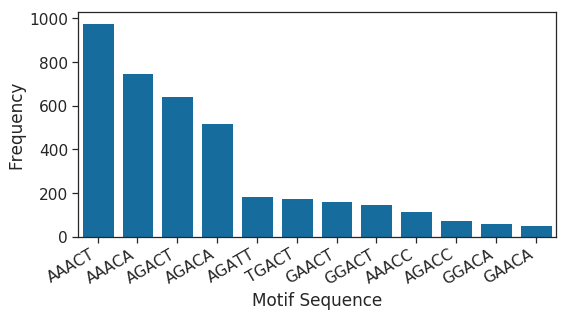

In [34]:
motif_seq_counts = pd.DataFrame(
    Counter(motif_seqs).most_common(),
    columns=['seq', 'count']
)

fig, ax = plt.subplots(figsize=(8, 4.5))

sns.barplot(
    x='seq',
    y='count',
    data=motif_seq_counts,
    color=pal[0],
    ax=ax
)
ax.set_xlabel('Motif Sequence')
ax.set_ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('figures/motif_sequences.svg')
plt.show()

Most of these have multiple adenosines i.e. would not be predicted by epinano:

In [135]:
has_multi_as = Counter([seq.count('A') > 1 for seq in  motif_seqs])
100 - (has_multi_as[False] / (len(motif_seqs)) * 100)

91.5525703952467

also at least one non canonical motif:

In [136]:
Counter(motif_seqs)['AGATT']

187

In [137]:
Counter(motif_seqs)['AGATT'] / len(motif_seqs) * 100

4.830793076724361

In [138]:
is_drach = Counter()
for seq in motif_seqs:
    if re.match('[AGT][AG]AC[ACT]', seq):
        is_drach[True] += 1
    else:
        is_drach[False] += 1
(is_drach[False] / (len(motif_seqs)) * 100)

4.830793076724361

In [35]:
g = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.chrom.sizes'
der_motif_site_count = to_df(
    der_motifs.slop(b=1, g=g).intersect(vir1_VIRc, c=True),
    colnames=['chrom', 'source', 'biotype', 'start', 'end', 'score', 'strand', 'frame', 'attrb', 'der_count']
).drop_duplicates(subset=['chrom', 'start', 'end'])
der_motif_site_count.head()

,chrom,source,biotype,start,end,score,strand,frame,attrb,der_count
0,1,fimo,nucleotide_motif,47574,47582,27.4,-,.,Name=DARACWW_1:47570-47585(-)+;Alias=MEME-1;ID...,3
1,1,fimo,nucleotide_motif,50187,50195,24.0,-,.,Name=DARACWW_1:50184-50197(-)+;Alias=MEME-1;ID...,1
2,1,fimo,nucleotide_motif,50237,50245,29.7,-,.,Name=DARACWW_1:50232-50252(-)+;Alias=MEME-1;ID...,7
3,1,fimo,nucleotide_motif,121169,121177,28.2,-,.,Name=DARACWW_1:121166-121179(-)+;Alias=MEME-1;...,1
4,1,fimo,nucleotide_motif,121204,121212,25.5,-,.,Name=DARACWW_1:121199-121212(-)+;Alias=MEME-1;...,3


In [36]:
np.median(der_motif_site_count.der_count)

1.0

In [37]:
np.percentile(der_motif_site_count.der_count, (2.5, 97.5))

array([1., 4.])

## DER site and miCLIP peak genic features barplots and stop codon metagene profiles

In [41]:
def parse_exons_introns_flank(record, flanksize=200):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',') + start
    exends = exstarts + np.fromstring(record[10], sep=',')
    exons = np.dstack([exstarts, exends])[0]
    left_flank = np.array([[max(0, start - flanksize), start]])
    right_flank = np.array([[end, end + flanksize]])
    if len(exons) > 1:
        introns = np.dstack([exons[:-1, 1], exons[1:, 0]])[0]
    else:
        introns = np.array([])
    return exons, introns, left_flank, right_flank


def split_intervals(invs, pos, side='left'):
    idx = np.searchsorted(invs.ravel(), pos)
    split = np.insert(invs.ravel(), idx, [pos, pos]).reshape(-1, 2)
    split_idx = (idx + 1) // 2
    return split[:split_idx], split[split_idx:]


def parse_cds_utr_introns_flank(record, flanksize):
    exons, introns, left_flank, right_flank = parse_exons_introns_flank(record, flanksize)
    cds_start = int(record[6])
    cds_end = int(record[7])
    utr1, cds = split_intervals(exons, cds_start)
    cds, utr2 = split_intervals(cds, cds_end)
    return utr1, cds, utr2, introns, left_flank, right_flank, exons


def parse_features(record, flanksize=200):
    features = {}
    invs = {}
    features['chrom'] = record[0].replace('Chr', '')
    features['strand'] = record[5]
    utr1, invs['cds'], utr2, invs['introns'], left_flank, right_flank, invs['exons'] = parse_cds_utr_introns_flank(record, flanksize)
    if features['strand'] == '+':
        invs['5utr'] = utr1
        invs['3utr'] = utr2
        invs['upstream'] = left_flank
        invs['downstream'] = right_flank
    else:
        invs['5utr'] = utr2
        invs['3utr'] = utr1
        invs['upstream'] = right_flank
        invs['downstream'] = left_flank
    features['invs'] = invs
    return features

genes_bed = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_protein_coding.201606.bed'


def get_lengths_for_norm():
    feat_lengths = Counter()
    with open(genes_bed) as bed:
        for record in bed:
            record = parse_features(record.split())
            if record['chrom'] in ['C', 'M']:
                continue
            for feat_type, invs in record['invs'].items():
                for inv in invs:
                    feat_lengths[feat_type] += (inv[1] - inv[0])
    return pd.Series(feat_lengths) / 1000


def count_mismatches_in_features(der_fn, use_strand=True):
    feature_counts = Counter()
    feat_lengths = get_lengths_for_norm()
    n_records = 0
    with open(genes_bed) as bed, pysam.TabixFile(der_fn) as tabix:
        for record in bed:
            record = parse_features(record.split())
            if record['chrom'] in ['C', 'M']:
                continue
            n_records += 1
            for feat_type, invs in record['invs'].items():
                for inv in invs:
                    if not inv[0] == inv[1]:
                        for mm in tabix.fetch(record['chrom'], *inv):
                            mm = mm.split('\t')
                            if use_strand:
                                if mm[5] == record['strand']:
                                    feature_counts[feat_type] += 1
                            else:
                                feature_counts[feat_type] += 1
    feature_counts = pd.Series(feature_counts) / feat_lengths
    return feature_counts, n_records

In [42]:
vir1_VIRc_feature_counts, n_records_der = count_mismatches_in_features(
    'vir1_VIRc_der_sites_thresholded.bed.gz',
)
miCLIP_feature_counts, n_records_miclip = count_mismatches_in_features(
    'miclip_peaks.bed.gz'
)
vir1_VIRc_feature_counts.head()

3utr          2.361561
5utr          0.002310
cds           0.009127
downstream    0.086191
exons         0.371992
dtype: float64

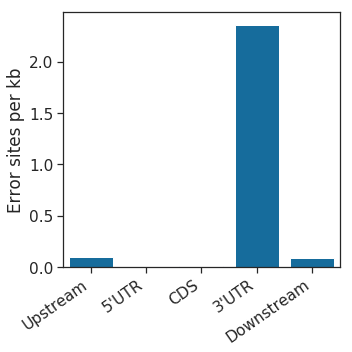

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    x='index',
    y=0,
    data=vir1_VIRc_feature_counts.reset_index(),
    color=pal[0],
    order=['upstream', '5utr', 'cds', '3utr', 'downstream'],
    ax=ax
)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_xlabel('')
ax.set_xticklabels(['Upstream', '5\'UTR', 'CDS', '3\'UTR', 'Downstream'])
ax.set_ylabel('Error sites per kb')
plt.tight_layout()
plt.savefig('figures/der_site_features.svg')
plt.show()

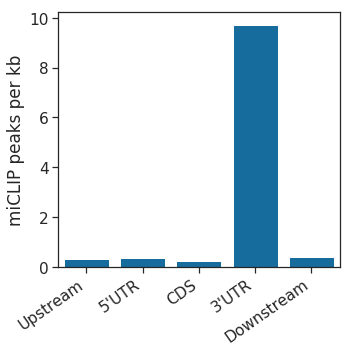

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    x='index',
    y=0,
    data=miCLIP_feature_counts.reset_index(),
    color=pal[0],
    order=['upstream', '5utr', 'cds', '3utr', 'downstream'],
    ax=ax
)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_xlabel('')
ax.set_xticklabels(['Upstream', '5\'UTR', 'CDS', '3\'UTR', 'Downstream'])
ax.set_ylabel('miCLIP peaks per kb')
plt.tight_layout()
plt.savefig('figures/miclip_site_features.svg')
plt.show()

In [47]:
def get_cds_region(bed, chrom, stop_pos, gene_strand, use_score=False, use_strand=True):
    region = np.zeros(1000, dtype=np.int32)
    try:
        bed_iter = bed.fetch(chrom, stop_pos - 500, stop_pos + 500)
    except ValueError:
        # no mismatches on Mt or Pt
        return region
    for record in bed_iter:
        record = record.split()
        pos = int(record[1])
        if pos > (stop_pos - 500) and pos < (stop_pos + 500):
            strand = record[5]
            if use_strand:
                if strand == gene_strand:
                    idx = pos - stop_pos + 500
                    region[idx] += float(record[4]) if use_score else 1
            else:
                idx = pos - stop_pos + 500
                region[idx] += float(record[4]) if use_score else 1
    return region

def get_stop_profiles(tabix_file, use_score=False, use_strand=True):
    stop_profiles = []
    mismatches = pysam.TabixFile(tabix_file)
    n_records = 0
    with open(genes_bed) as bed:
        for record in bed:
            record = record.split()
            chrom = record[0].replace('Chr', '')
            if chrom in 'MC':
                continue
            strand = record[5]
            cds_end = int(record[7]) if strand == '+' else int(record[6])
            stop_prof = get_cds_region(mismatches, chrom, cds_end, strand, use_score=use_score, use_strand=use_strand)
            if strand == '-':
                stop_prof = stop_prof[::-1]
            n_records += 1
            stop_profiles.append(stop_prof)
    mismatches.close()
    return stop_profiles, n_records

In [48]:
der_site_stop_profiles, n_records_der = get_stop_profiles('vir1_VIRc_der_sites_thresholded.bed.gz')
miclip_stop_profiles, n_records_miclip = get_stop_profiles('miclip_peaks.bed.gz')

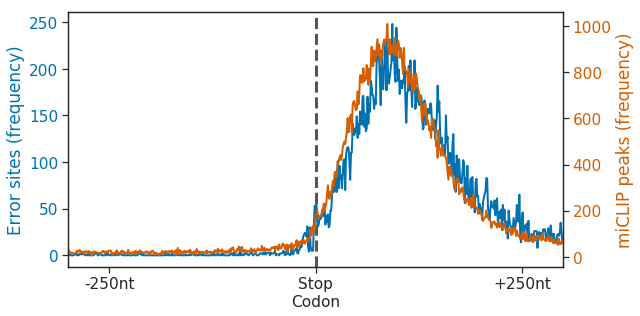

In [49]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(np.sum(der_site_stop_profiles, axis=0), color=pal[0], lw=2, zorder=1)
ax2 = ax.twinx()
ax2.plot(np.sum(miclip_stop_profiles, axis=0), color=pal[1], lw=2, zorder=0)
ax.axvline(500, color='#555555', ls='--', lw=3, zorder=-1)
ax.set_xticks([250, 500, 750])
plt.setp(ax2.get_yticklabels(), color=pal[1])
plt.setp(ax.get_yticklabels(), color=pal[0])
ax.set_xticklabels(['-250nt', 'Stop\nCodon', '+250nt'])
ax2.set_ylabel('miCLIP peaks (frequency)', color=pal[1])
ax.set_ylabel('Error sites (frequency)', color=pal[0])
ax.set_xlim(200, 800)
plt.tight_layout()
plt.savefig('figures/stop_codon_metaplot.svg')
plt.show()

## Relationship between DER sites and 3' ends (in vir and VIRc)

In [50]:
class MultiBW(object):

    def __init__(self, fns):
        self._fns = fns
        self._handles = [pybw.open(fn) for fn in fns]

    def values(self, chrom, start, end, **kwargs):
        kwargs['numpy'] = True
        vals = np.zeros(shape=(end - start,))
        for bw in self._handles:
            vals += bw.values(chrom, start, end, **kwargs)
        return vals

    def close(self):
        for bw in self._handles:
            bw.close()


def tpp(pos_bw, neg_bw, chrom, start, end, strand):
    bw = pos_bw if strand == '+' else neg_bw
    vals = bw.values(chrom, start, end, numpy=True)
    vals[np.isnan(vals)] = 0.0
    if strand == '-':
        vals = vals[::-1]
    dists = np.repeat(np.arange(len(vals)), vals.astype('i'))
    return dists


def get_three_prime_end_profiles(der_motifs_fn, pos_bw_fns, neg_bw_fns, flank=200):
    pos_bw = MultiBW(pos_bw_fns)
    neg_bw = MultiBW(neg_bw_fns)
    dist_to_three_prime = []
    with open(der_motifs_fn) as der_motifs:
        for record in der_motifs:
            record = record.split()
            chrom = record[0]
            start = int(record[1])
            end = int(record[2])
            strand = record[5]
            dists = tpp(pos_bw, neg_bw, chrom, start - flank, start + flank, strand)
            dist_to_three_prime.append(dists)
    dist_to_three_prime = np.concatenate(dist_to_three_prime) - flank
    return dist_to_three_prime

In [51]:
VIRc_profiles = get_three_prime_end_profiles(
    '../vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed',
    glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/*VIR*/aligned_data/TAIR10/*_fwd_three-prime.bigwig'),
    glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/*VIR*/aligned_data/TAIR10/*_rev_three-prime.bigwig'),
)
vir1_profiles = get_three_prime_end_profiles(
    '../vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed',
    glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/*vir*/aligned_data/TAIR10/*_fwd_three-prime.bigwig'),
    glob('/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/*vir*/aligned_data/TAIR10/*_rev_three-prime.bigwig')
)


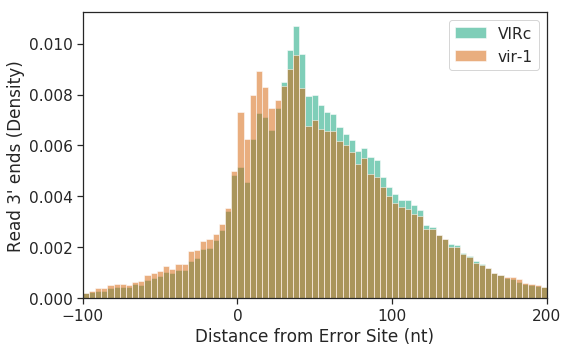

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(
    VIRc_profiles,
    bins=np.linspace(-100, 200, 76),
    density=True, alpha=0.5, color=pal[2],
    label='VIRc'
)
ax.hist(
    vir1_profiles,
    bins=np.linspace(-100, 200, 76),
    density=True, alpha=0.5, color=pal[1],
    label='vir-1'
)
ax.set_xlim(-100, 200)
ax.set_xticks([-100, 0, 100, 200])
ax.set_xlabel('Distance from Error Site (nt)')
ax.set_ylabel('Read 3\' ends (Density)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/error_site_to_three_prime_distance.svg')

plt.show()

(-10, 40)

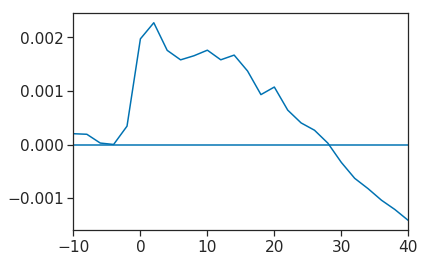

In [53]:
bins = np.linspace(-200, 200, 201)
diff = np.histogram(vir1_profiles, bins=bins, density=True)[0] - \
       np.histogram(VIRc_profiles, bins=bins, density=True)[0]
fig, ax = plt.subplots()
plt.plot(bins[:-1], diff)
ax.axhline(0)
ax.set_xlim(-10, 40)

## Expression analysis

In [62]:
der_genes_df = to_df(der_genes, colnames=['chrom', 'start', 'end', 'gene_id', 'score', 'strand'])
der_genes_df.head()

,chrom,start,end,gene_id,score,strand
0,1,31169,33171,AT1G01050,.,-
1,1,44969,47059,AT1G01080,.,-
2,1,47233,49304,AT1G01090,.,-
3,1,49908,51210,AT1G01100,.,-
4,1,72338,74096,AT1G01160,.,+


In [55]:
de_analysis = pd.read_excel(
    '/cluster/ggs_lab/mtparker/nanopore_differential_expression/vir1_de_analysis/vir1_vs_VIRc_nanopore_differential_expression.xlsx',
    index_col=0,
    usecols=[0, 1, 2, 4, 5])
de_analysis.columns = ['logFC', 'logCPM', 'PValue', 'FDR']
de_analysis.head()

,logFC,logCPM,PValue,FDR
gene_id,,,,
AT1G67105,8.679788,8.790894,1.257789e-220,2.485140e-216
AT2G01422,10.198674,5.840274,3.073371e-92,3.036183e-88
AT4G12480,4.763961,6.409932,7.175015e-85,4.725465e-81
AT1G53480,5.986196,5.295662,2.499343e-60,1.234551e-56
AT3G05685,-4.577826,5.003789,3.999775e-48,1.580551e-44


In [63]:
ill_de_analysis = pd.read_csv(
    '/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/vir_fpa_35SFPA_rnaseq/differential_expression/edgeR/vir1_vs_VIR_GFP.tsv',
    sep='\t'
).set_index('gene_id')
ill_de_analysis.head()

,logFC,logCPM,LR,PValue,FDR,VIR_GFP_1,VIR_GFP_2,VIR_GFP_3,VIR_GFP_4,VIR_GFP_5,VIR_GFP_6,vir1_1,vir1_2,vir1_3,vir1_4,vir1_5,vir1_6
gene_id,,,,,,,,,,,,,,,,,
AT1G01010,0.790845,2.361813,25.876753,3.639256e-07,1.518096e-06,2.269714,1.561109,2.163393,1.818121,1.652585,1.679491,2.682190,2.940875,2.450672,2.597384,2.686535,2.931528
AT1G01020,-0.140449,3.672068,1.234412,2.665507e-01,3.365443e-01,3.547301,4.072477,3.652994,3.903416,3.384997,3.426883,3.546279,3.661962,3.562402,3.744076,3.615279,3.788169
AT1G01030,0.891376,3.037784,26.356156,2.839125e-07,1.207498e-06,2.530996,2.891722,2.496387,2.453620,2.492353,1.900039,3.376404,3.567747,3.420286,2.895583,3.789888,3.470110
AT1G01040,0.844240,5.423772,76.598408,2.095085e-18,4.353242e-17,5.291489,4.855951,4.683981,4.710100,4.825953,4.899644,5.878127,5.756132,5.630622,5.771283,5.937666,5.873470
AT1G01050,-0.270318,5.265209,9.960478,1.599365e-03,3.485792e-03,5.404978,5.365834,5.357224,5.510981,5.168253,5.383013,5.081752,5.218865,5.038693,5.107933,5.033473,5.412312


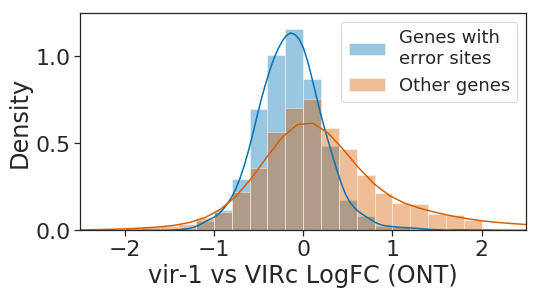

In [64]:
sns.set(font_scale=2, style=style)
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(de_analysis[de_analysis.index.isin(der_genes_df.gene_id)].logFC,
             bins=np.linspace(-2, 2, 21),
             kde_kws={'bw': 0.2},
             color=pal[0],
             label='Genes with\nerror sites')
sns.distplot(de_analysis[~de_analysis.index.isin(der_genes_df.gene_id)].logFC,
             bins=np.linspace(-2, 2, 21),
             kde_kws={'bw': 0.2},
             color=pal[1],
             label='Other genes')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(0, 1.25)
ax.set_xlabel('vir-1 vs VIRc LogFC (ONT)')
ax.set_ylabel('Density')
plt.legend(loc=0, fontsize=18)
plt.savefig('figures/nanopore_der_exprs.svg')
plt.show()

In [65]:
print(
    len(de_analysis[de_analysis.index.isin(der_genes_df.gene_id)]),
    len(de_analysis[~de_analysis.index.isin(der_genes_df.gene_id)])
)

5083 14675


In [66]:
stats.mannwhitneyu(
    de_analysis[de_analysis.index.isin(der_genes_df.gene_id)].logFC,
    de_analysis[~de_analysis.index.isin(der_genes_df.gene_id)].logFC
)

MannwhitneyuResult(statistic=24212339.5, pvalue=2.299381033485119e-305)

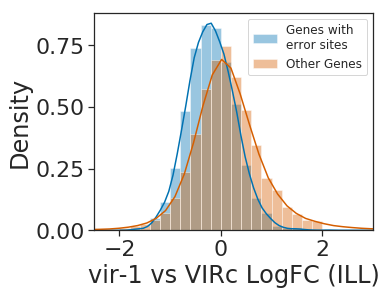

In [67]:
sns.set(font_scale=2, style=style)
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(ill_de_analysis[ill_de_analysis.index.isin(der_genes_df.gene_id)].logFC,
             bins=np.linspace(-2, 2, 21),
             kde_kws={'bw': 0.2},
             color=pal[0],
             label='Genes with\nerror sites')
sns.distplot(ill_de_analysis[~ill_de_analysis.index.isin(der_genes_df.gene_id)].logFC,
             bins=np.linspace(-2, 2, 21),
             kde_kws={'bw': 0.2},
             color=pal[1],
             label='Other Genes')
ax.set_xlim(-2.5, 3)
ax.set_xlabel('vir-1 vs VIRc LogFC (ILL)')
ax.set_ylabel('Density')
plt.legend(loc=0, fontsize=12)
plt.savefig('figures/illumina_der_exprs.svg')
plt.show()

In [68]:
print(
    len(ill_de_analysis[ill_de_analysis.index.isin(der_genes_df.gene_id)]),
    len(ill_de_analysis[~ill_de_analysis.index.isin(der_genes_df.gene_id)])
)

5095 14686
